# NLP

In [1]:
import re
import nltk
import spacy
import pyLDAvis
import numpy as np
import pandas as pd
import pyLDAvis.lda_model
from textblob import TextBlob
from nltk.corpus import words
import matplotlib.pyplot as plt
from sklearn import preprocessing
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Run once to download necessary corpora.
# nltk.download('words')
# nltk.download('punkt')
# nltk.download('stopwords')
# spacy.cli.download('en_core_web_lg')

## Load & Inspect Text

In [3]:
# View data & extract description.
df = pd.read_csv("wine_review.csv")
display(df)

,points,superior_rating,price,variety,Crisp,Dry,Finish,Firm,Fresh,Fruit,Full,Rich,Round,Soft,Sweet,description
0,91,1,43,Champagne Blend,0,1,1,0,0,0,0,1,1,0,0,"Has round, complete, aged Champagne aromas of ..."
1,87,0,17,Bordeaux-style Red Blend,0,0,0,0,0,1,0,0,0,0,0,This well-balanced wine is both fruity and str...
2,87,0,34,Champagne Blend,0,0,0,1,0,1,1,0,0,0,0,"A full, creamy wine with a big mousse that fil..."
3,90,1,35,Rosé,1,0,1,0,0,1,1,0,0,1,0,This is the top wine from the Sainte Roseline ...
4,87,0,45,Chardonnay,1,0,0,0,0,0,0,0,0,1,0,This is a blend from seven of Pascal Agrapart'...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,93,1,61,Riesling,0,0,0,0,0,1,0,0,0,0,0,"This late release, aging for five years, has p..."
2496,90,1,25,Rosé,1,0,0,0,1,1,0,0,0,0,0,The wine comes from the western end of the Côt...
2497,85,0,15,Bordeaux-style Red Blend,0,1,0,1,1,1,0,0,0,0,0,A tribute to the year—1935—of the founding of ...
2498,88,0,12,Rhône-style Red Blend,0,0,1,0,0,0,0,0,1,0,0,"Unlike most Côtes du Rhônes, this one is based..."


In [4]:
# Check for null values.
df.isnull().sum()
# No null values.

points             0
superior_rating    0
price              0
variety            0
Crisp              0
Dry                0
Finish             0
Firm               0
Fresh              0
Fruit              0
Full               0
Rich               0
Round              0
Soft               0
Sweet              0
description        0
dtype: int64

In [5]:
# # Inspect text.
# with open("review_text.txt", "w", encoding="utf-8") as f:
#     f.write(" ".join(df['description']))

<font color='#8888ff'><u>OBSERVATIONS:</u></font>
* Text is relatively clean.
* Special characters limited to "(", ")", "-" and some letters with accents.
* Word contractions like "it's" exist and may benefit from explansion (to "it is").

## Cleaning

<font color='#ff88ff'><u>COMMENTS:</u></font> Given previous observations, cleaning would involve the following steps.
* Make lowercase.
* Remove sepcial characters that are not letters, numbers or "%". The decision is made to retain numbers and "%" as percent of certain aspects present/absent in wine might be a useful indicator of its rating.
* Expand contractions. List of common contractions obtained from: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python.
* Word contractions like "it's" exist and may benefit from explansion (to "it is").
* Remove "'s" that indicates belonging. This was not done before expanding  to avoid removing different contractions like "he's".
* Remove extra spaces.
* At the end of regex substitution, if the review contains no letters, then empty string is returned. Later all empty reviews in the DF is dropped.


In [6]:
contractions = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
}

def clean(text):
    """ Function that returns text after cleaning it. 
        @param text: Input text.
        @return text: Clean text.
    """
    # Make lowercase.
    text = text.lower().strip()

    # Expand contractions.
    for key, val in contractions.items():
        text = re.sub(key, val, text)

    # Discard "'s" indicating belonging.
    text = re.sub("'s","",text)

    # Remove all special characters other than
    # letters, numbers and "%".
    text = re.sub("[^a-z0-9%]", " ", text)

    # Discard extra spaces.
    text = re.sub('\\s\\s+', " ", text).strip()
    
    # If final text after cleaning is empty, return "".
    if re.search("[a-z0-9%]", text): 
        return text
    else: return ""

In [7]:
description_processed = df["description"].apply(lambda text: clean(text))

## Text Processing & Normalization

<font color='#ff88ff'><u>COMMENTS:</u></font> Stop words are words like "and", "an", "a", etc. that are important for grammar but don't contr

In [11]:
stop_words = set(stopwords.words('english'))
stop_words.add("wine") # Adding wine as stop word just to remove it from the description.
# This data set is about wine. So the word "wine" does not convey much information.
def remove_stopwords(text): # (M.D. Pietro, 2017)
    """
    Function that removes stopwords from a given list of word
    and returns this new possibly smaller list.
    @param text: The list of words from which to remove stopwords.
    @return text: Text without stop words.
    """
    return " ".join([word for word in text.split(" ") if not word in stop_words])

In [12]:
description_processed = description_processed.apply(lambda text: remove_stopwords(text))

In [13]:
english_words = set(words.words())
def eng_filter(text):
    """
    Filters out non-english words.
    @param text: Input text.
    @return: Sentence with english words only.
    """
    filtered_text = ' '.join(
        word for word in text.split() 
        if word.lower() in english_words
    )
    return filtered_text

In [14]:
description_processed = description_processed.apply(lambda text: eng_filter(text))

## Lemmatization

<font color='#ff88ff'><u>COMMENTS:</u></font> Lemmatization is the process of converting words to their root word. Various tenses and forms of words are reduced to their base words to reduce no. of words in the corpus while keeping meaning intact.

In [15]:
spacy_nlp_en = spacy.load("en_core_web_lg")
def lemmatize(text):
    """ 
    Lemmatizes a given text string.
    @param text_list: List of strings.
    @return: Text containing lemmatized words.
    """
    doc = spacy_nlp_en(text)
    return " ".join([token.lemma_ for token in doc])

In [19]:
description_processed = description_processed.apply(lambda text: lemmatize(text))

In [20]:
description_processed

0       round complete aged champagne warm biscuit nut...
1       well balanced fruity structure good acidity bl...
2       full creamy big mousse mouth fruit restrain st...
3       top estate perfect salmon pink color ripe full...
4       blend seven less important young many crisp ci...
                              ...                        
2495    late release age five produce majestic breadth...
2496    come western end c de foot massive mountain li...
2497    tribute year found gur structure dry ripe plum...
2498    unlike c one base small proportion use blend r...
2499    honey toast broad moderately rich example bit ...
Name: description, Length: 2500, dtype: object

## Extract Sentiment

In [21]:
def get_sentiment(text):
    """ 
    Uses the textblob library to return sentiment
    of the given text.
    @param text: Text to analyse.
    @return: Sentiment [-1, 1] with -1 = most negative
             and +1 = most positive.
    """
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [22]:
sentiment = description_processed.apply(lambda text: np.round(get_sentiment(text), 3))

In [23]:
df['description_processed'] = description_processed
df['sentiment'] = sentiment

In [24]:
df[['superior_rating', 'sentiment', 'description_processed']][df['sentiment'] >= 0.7]

,superior_rating,sentiment,description_processed
280,0,1.000,ripe creamy well rounded herbal apple skin del...
864,1,0.750,elegant expression plum skin spice delicious j...
1015,1,0.717,blend wonderful freshness vivacity combine hon...
1640,0,0.750,attractively perfumed blend spicy bright chara...
2231,0,0.800,blanc burst perfumed acidity dominate melon le...


In [25]:
df.sentiment.describe()

count    2500.000000
mean        0.188848
std         0.163774
min        -0.400000
25%         0.083000
50%         0.192000
75%         0.300000
max         1.000000
Name: sentiment, dtype: float64

In [26]:
# Extract useful features only.
df_useful = df[[
    'superior_rating', 'price', 'variety', 'Crisp', 'Dry', "Sweet",
    'Finish', 'Firm', 'Fresh', 'Fruit', 'Full', 'Rich', 'Round', 
    'Soft', 'sentiment', 'variety_c'
]]

## Feature Extraction


### Encode Variety Names

In [12]:
# Adding a new column with shortened variety names.
names2code = {
    "Champagne Blend":"Cd", 
    "Bordeaux-style Red Blend":"BR",
    "Rosé":"Re", 
    "Chardonnay":"Cy", 
    "Syrah":"Sh", 
    "Red Blend":"Rd", 
    "Gamay":"Gy", 
    "Gewürztraminer":"Gr",
    "Chenin Blanc":"Cc", 
    "Alsace white blend":"Ad", 
    "Tannat":"Tt", 
    "White Blend":"Wd", 
    "Rhône-style Red Blend":"RR", 
    "Muscat":"Mt",
    "Bordeaux-style White Blend":"BW", 
    "Pinot Noir":"Pr",
    "Malbec":"Mc", 
    "Merlot":"Mr", 
    "Sauvignon Blanc":"Sc",
    "Viognier":"Vr", 
    "Pinot Gris":"Ps", 
    "Cabernet Franc":"CF",
    "Riesling":"Rg", 
    "Tannat-Cabernet":"TC", 
    "Marsanne":"Me",
    "Pinot Blanc":"Pc", 
    "Cabernet Sauvignon":"Cn", 
    "Rhône-style White Blend":"RW", 
    "Grenache":"Ge",
    "Sparkling Blend":"Sd", 
    "Malbec-Merlot":"MM",
    "Sylvaner":"Sr", 
    "Melon":"Mn", 
    "Chenin Blanc-Chardonnay":"CB", 
    "Petit Manseng":"Pg"
}
df_useful['variety_c'] = df_useful['variety'].apply(lambda v: names2code[v])

### Add Price Bracket

Create a price bracket column containing. Price brackets (what price range the wine belongs to) were determined based on information from around 2016 from: https://winefolly.com/lifestyle/reality-of-wine-prices-what-you-get-for-what-you-spend/ .

In [15]:
price_name2code = {
  "Extreme Value":"EV", "Value":"V", "Popular Premium":"PP",
  "Premium":"P", "Super Premium":"SP", "Ultra Premium":"UP",
  "Luxury":"L", "Super Luxury":"SL", "Icon":"I"
}
price_code2name = {
  "EV":"Extreme Value", "V":"Value", "PP":"Popular Premium",
  "P":"Premium", "SP":"Super Premium", "UP":"Ultra Premium",
  "L":"Luxury", "SL":"Super Luxury", "I":"Icon"
}
price_bracket = []
for price in df_useful['price']:
    if price < 4: price_bracket.append("EV")
    elif price < 10: price_bracket.append("V")
    elif price < 15: price_bracket.append("PP")
    elif price < 20: price_bracket.append("P")
    elif price < 30: price_bracket.append("SP")
    elif price < 50: price_bracket.append("UP")
    elif price < 100: price_bracket.append("L")
    elif price < 200: price_bracket.append("SL")
    else: price_bracket.append("I")
df_useful['price_bracket'] = price_bracket

### Add wine characteristic scores.

This section tries to isolate and extract key characteristics of wine. Wine is usually judged based on 5 key characteristics as follows.
Reference: https://winefolly.com/deep-dive/wine-characteristics/.
1. Sweetness: How sweet or dry (not sweet)?
2. Acidity: How tart?
3. Tannin: How astringent or bitter?
4. Alcohol: How much does the wine warm the throat?
5. Body: Weight/richness/fullness/roundness of wine in the mouth.

In [27]:
df_text = pd.DataFrame({
    'is_superior': df['superior_rating'],
    'review': df['description_processed']
})
df_text

,is_superior,review
0,1,round complete aged champagne warm biscuit nut...
1,0,well balanced fruity structure good acidity bl...
2,0,full creamy big mousse mouth fruit restrain st...
3,1,top estate perfect salmon pink color ripe full...
4,0,blend seven less important young many crisp ci...
...,...,...
2495,1,late release age five produce majestic breadth...
2496,1,come western end c de foot massive mountain li...
2497,0,tribute year found gur structure dry ripe plum...
2498,0,unlike c one base small proportion use blend r...


In [28]:
character_points_map = {
    "sweetness": {
        1: ["sweet", "sugar", "dessert", "fruit", "honey", "sacchar", "lush", "ripe"], 
        -1: ["dry", "crisp", "tart", "austere", "sharp", "astringent", "tangy", "brac", "acid", "sour"]
    },
    "acidity": {
        1: ["acidic", "tart", "tang", "zest", "sharp", "crisp", "brac", "bright", "zing", "live"], 
        -1: ["sweet", "mellow", "smooth", "velvet", "round", "soft", "lush", "creamy", "full", "rich"]
    },
    "tannin": {
        1: ["tannin", "astringent", "grip", "structure", "firm", "texture"],
        -1: ["smooth", "soft", "silk", "velvet", "mellow", "round"]
    },
    "alcohol": {
        1: ["alcohol", "drunk", "spirit", "booze", "bubbl", "liquor", "hooch", "fort", "hot", "warm", "spic", "full"],
        -1: ["dry", "crisp", "tart", "austere", "sharp", "acid", "bitter", "astringent", "tangy", "tannic"]
    },
    "body": {
        1: ["bod", "struct", "full", "weight", "mouthfeel", "texture", "rich", "depth", "deep", "substance", "visc"],
        -1: ["light", "thin", "water", "delicate", "weak", "insubstantial", "flimsy", "dilute", "lack", "air"]
    }
}

In [29]:
def get_character_scores(text):
    """ 
    Given some text returns corresponding wine
    characteristics (sweetness, acidity, tanning, alcohol, body)
    related scores based on words in the text.
    @param text: Text to analyze.
    @return: Dictionary of min max normalized characteristic scores
             such that 0.5 => neutral, 0 => opposite characteristic,
             and 1 => most positive indicator of characteristic.
    """
    text_vec = text.split()
    character_score = {"sweetness":0, "acidity":0, "tannin":0, "alcohol":0, "body":0}
    norm_num = 0
    for i in range(0, len(text_vec), 3): # Loop through text, 3 words at a time.
        norm_num += 1
        text_segment = " ".join(text_vec[i:i+3])
        for character in character_points_map.keys():
            score = 0
            for char_text in character_points_map[character][1]:
                if char_text in text_segment: score += 1
            for opp_char_text in character_points_map[character][-1]:
                if opp_char_text in text_segment: score -= 1
            character_score[character] += score
    for k, v in character_score.items():
        character_score[k] = np.round((v-(-1*norm_num))/(norm_num-(-1*norm_num)), 3)
    return character_score

In [30]:
df_char_scores = pd.DataFrame.from_dict([
    get_character_scores(text) 
    for text in df_text['review'].to_numpy().tolist()
])
df_char_scores

,sweetness,acidity,tannin,alcohol,body
0,0.438,0.312,0.438,0.688,0.625
1,0.500,0.625,0.625,0.500,0.500
2,0.583,0.333,0.667,0.583,0.667
3,0.429,0.429,0.429,0.500,0.500
4,0.375,0.500,0.375,0.375,0.500
...,...,...,...,...,...
2495,0.600,0.450,0.550,0.500,0.550
2496,0.500,0.643,0.500,0.429,0.429
2497,0.400,0.500,0.700,0.300,0.500
2498,0.500,0.438,0.375,0.500,0.500


In [31]:
df_useful = pd.concat([df_useful, df_char_scores], axis=1)

In [32]:
df_useful

,superior_rating,price,variety,Crisp,Dry,Sweet,Finish,Firm,Fresh,Fruit,...,Rich,Round,Soft,sentiment,variety_c,sweetness,acidity,tannin,alcohol,body
0,1,43,Champagne Blend,0,1,0,1,0,0,0,...,1,1,0,0.183,Cd,0.438,0.312,0.438,0.688,0.625
1,0,17,Bordeaux-style Red Blend,0,0,0,0,0,0,1,...,0,0,0,0.300,BR,0.500,0.625,0.625,0.500,0.500
2,0,34,Champagne Blend,0,0,0,0,1,0,1,...,0,0,0,0.062,Cd,0.583,0.333,0.667,0.583,0.667
3,1,35,Rosé,1,0,0,1,0,0,1,...,0,0,1,0.312,Re,0.429,0.429,0.429,0.500,0.500
4,0,45,Chardonnay,1,0,0,0,0,0,0,...,0,0,1,0.217,Cy,0.375,0.500,0.375,0.375,0.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1,61,Riesling,0,0,0,0,0,0,1,...,0,0,0,0.109,Rg,0.600,0.450,0.550,0.500,0.550
2496,1,25,Rosé,1,0,0,0,0,1,1,...,0,0,0,0.328,Re,0.500,0.643,0.500,0.429,0.429
2497,0,15,Bordeaux-style Red Blend,0,1,0,0,1,1,1,...,0,0,0,-0.144,BR,0.400,0.500,0.700,0.300,0.500
2498,0,12,Rhône-style Red Blend,0,0,0,1,0,0,0,...,0,1,0,-0.264,RR,0.500,0.438,0.375,0.500,0.500


In [33]:
# # Save useful features only.
# df_useful.to_csv("wine_review_processed.csv", index=False)

In [34]:
vectorizer_tfidf = TfidfVectorizer(ngram_range=(1,1))
vectorizer_tfidf.fit(df_text['review'])
review_tfidf = vectorizer_tfidf.transform(df_text['review']).toarray()

In [35]:
# Reduce TF-IDF vectors with 2796 words to have 2 components
# using the T-SNE algorithm.
tsne1 = TSNE(n_components=1, random_state=23) # (2500, 2796) -> (2500, 1)
tfidf_reduced1 = tsne1.fit_transform(review_tfidf)
tsne2 = TSNE(n_components=2, random_state=23) # (2500, 2796) -> (2500, 2)
tfidf_reduced2 = tsne2.fit_transform(review_tfidf)
tsne3 = TSNE(n_components=3, random_state=23) # (2500, 2796) -> (2500, 3)
tfidf_reduced3 = tsne3.fit_transform(review_tfidf)

In [36]:
# Get index of superior and non-superior wines.
idx_sup = (df_text[df_text["is_superior"] == 1]).index
idx_inf = (df_text[df_text["is_superior"] == 0]).index

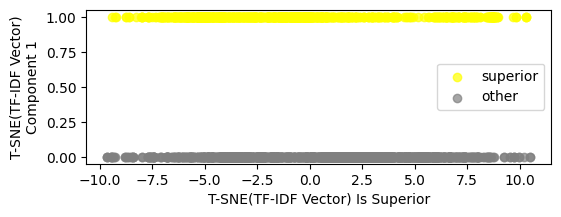

In [37]:
# Visualize 1D TF-IDF reduction result.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 2))
ax.scatter( # superior
    tfidf_reduced1[idx_sup], 
    df_text['is_superior'][idx_sup],
    c='yellow', alpha=0.7, label='superior'
)
ax.scatter( # not superior
    tfidf_reduced1[idx_inf], 
    df_text['is_superior'][idx_inf],
    c='gray', alpha=0.7, label='other'
)
ax.set_xlabel('T-SNE(TF-IDF Vector) Is Superior')
ax.set_ylabel('T-SNE(TF-IDF Vector)\nComponent 1')
ax.legend()
plt.show()

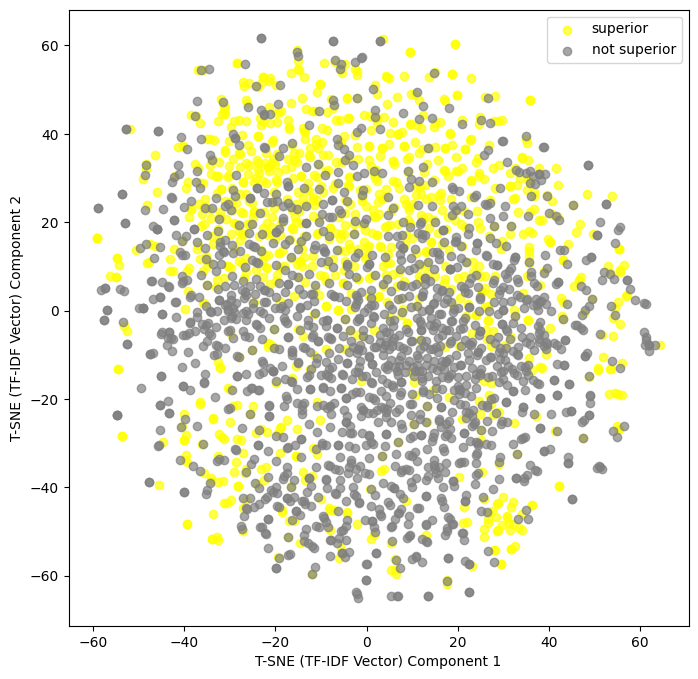

In [38]:
# Display reduced results to check for clusters.
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
ax.scatter( # superior
    tfidf_reduced2[idx_sup, 0], 
    tfidf_reduced2[idx_sup, 1], 
    c='yellow', alpha=0.7, label='superior'
)
ax.scatter( # superior
    tfidf_reduced2[idx_inf, 0], 
    tfidf_reduced2[idx_inf, 1], 
    c='gray', alpha=0.7, label='not superior'
)
ax.set_xlabel('T-SNE (TF-IDF Vector) Component 1')
ax.set_ylabel('T-SNE (TF-IDF Vector) Component 2')
ax.legend()
plt.show()

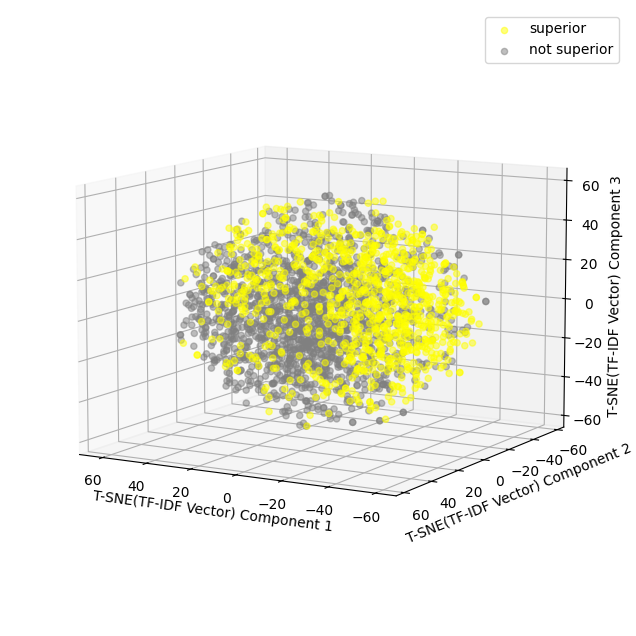

In [39]:
# Display reduced results to check for clusters.
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter( # superior
    tfidf_reduced3[idx_sup, 0], 
    tfidf_reduced3[idx_sup, 1], 
    tfidf_reduced3[idx_sup, 2],
    c='yellow', alpha=0.5, label='superior'
)
ax.scatter( # superior
    tfidf_reduced3[idx_inf, 0], 
    tfidf_reduced3[idx_inf, 1], 
    tfidf_reduced3[idx_inf, 2],
    c='gray', alpha=0.5, label='not superior'
)
ax.set_xlabel('T-SNE(TF-IDF Vector) Component 1')
ax.set_ylabel('T-SNE(TF-IDF Vector) Component 2')
ax.set_zlabel('T-SNE(TF-IDF Vector) Component 3')

ax.view_init(elev=10, azim=120)
ax.set_box_aspect(aspect=None, zoom=0.9)

ax.legend()
plt.show()

In [40]:
df_useful['tfidf_tsne_1'] = tfidf_reduced2[:,0]
df_useful['tfidf_tsne_2'] = tfidf_reduced2[:,1]

## Topic Modelling

Topic modelling here, involves extracting latent themes from word vectors. Latent Dirichlet Allocation (LDA) is a commonly used Bayesian approach to topic modelling.

In [41]:
# Get descriptions of superior and non-superior wines. 
description_superior = description_processed[df['superior_rating']==1]
description_other = description_processed[df['superior_rating']==0]

In [42]:
tf_vectorizer = CountVectorizer(ngram_range=(1,3))

In [40]:
# # SUPERIOR RATED.
# tf_mat_sup = tf_vectorizer.fit_transform(description_superior)
# lda = LatentDirichletAllocation(n_components=3, random_state=23)
# lda.fit(tf_mat_sup)
# LDAvis_prepared = pyLDAvis.lda_model.prepare(lda, tf_mat_sup, tf_vectorizer)
# pyLDAvis.display(LDAvis_prepared, template_type='notebook')

In [41]:
# # OTHER RATED.
# tf_mat_other = tf_vectorizer.fit_transform(description_other)
# lda = LatentDirichletAllocation(n_components=3, random_state=23)
# lda.fit(tf_mat_other)
# LDAvis_prepared = pyLDAvis.lda_model.prepare(lda, tf_mat_other, tf_vectorizer)
# pyLDAvis.display(LDAvis_prepared, template_type='notebook')

In [42]:
# # BOTH.
# tf_mat_both = tf_vectorizer.fit_transform(description_processed)
# lda = LatentDirichletAllocation(n_components=2, random_state=23)
# lda.fit(tf_mat_both)
# LDAvis_prepared = pyLDAvis.lda_model.prepare(lda, tf_mat_both, tf_vectorizer)
# pyLDAvis.display(LDAvis_prepared, template_type='notebook')

In [43]:
review_tf = tf_vectorizer.fit_transform(df_text['review'])
idx_ready = np.where(tf_vectorizer.get_feature_names_out() == 'ready')[0][0]

In [44]:
df_useful['Ready'] = [int(v) for v in (review_tf[:, idx_ready].toarray().flatten() > 0)]

In [45]:
df_useful

,superior_rating,price,variety,Crisp,Dry,Sweet,Finish,Firm,Fresh,Fruit,...,sentiment,variety_c,sweetness,acidity,tannin,alcohol,body,tfidf_tsne_1,tfidf_tsne_2,Ready
0,1,43,Champagne Blend,0,1,0,1,0,0,0,...,0.183,Cd,0.438,0.312,0.438,0.688,0.625,42.099899,28.478207,0
1,0,17,Bordeaux-style Red Blend,0,0,0,0,0,0,1,...,0.300,BR,0.500,0.625,0.625,0.500,0.500,-2.522829,12.224195,0
2,0,34,Champagne Blend,0,0,0,0,1,0,1,...,0.062,Cd,0.583,0.333,0.667,0.583,0.667,29.801601,38.319843,0
3,1,35,Rosé,1,0,0,1,0,0,1,...,0.312,Re,0.429,0.429,0.429,0.500,0.500,25.015181,-29.282564,0
4,0,45,Chardonnay,1,0,0,0,0,0,0,...,0.217,Cy,0.375,0.500,0.375,0.375,0.500,46.969723,-3.859226,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,1,61,Riesling,0,0,0,0,0,0,1,...,0.109,Rg,0.600,0.450,0.550,0.500,0.550,-6.954199,56.169823,1
2496,1,25,Rosé,1,0,0,0,0,1,1,...,0.328,Re,0.500,0.643,0.500,0.429,0.429,29.087440,-22.926741,0
2497,0,15,Bordeaux-style Red Blend,0,1,0,0,1,1,1,...,-0.144,BR,0.400,0.500,0.700,0.300,0.500,-20.420696,-4.173007,0
2498,0,12,Rhône-style Red Blend,0,0,0,1,0,0,0,...,-0.264,RR,0.500,0.438,0.375,0.500,0.500,-3.805027,-30.743109,0


## Save Processed Data

In [16]:
# # Save useful features only.
# df_useful.to_csv("wine_review_processed.csv", index=False)